# Environmental Effects on Beam Position Drift

## <font color='coral'>Introduction</font><a class="anchor" id="Intro"></a>

The electron beam in the Australian Synchrotron is as narrow as a human hair (322.9 micrometers). It orbits inside a vacuum chamber, following the 215m circular tube. The narrow cross section of the vacuum tube is only 6.4mm wide in some places, which is why the beam is programmatically constrained to a 1mm radius window transverse to it's orbital path. Beam stability within this window is important for many reasons including, instrumentation sensitivity, keeping radiation levels low and maintaining consistent x-ray flux for our beamline research stations. 

The accelerator is made up of materials such as stainless steel and ceramics which are sensitive to thermal expansion, while coaxial cable (used for signal transfer along very long routes) is sensitive to moisture. Additionally, it is unknown whether the beam position monitoring (BPM) instrumentation is climate sensitive. So it is understandable that small changes in environmental conditions can cause either the appearance of, or real shifts in the beam position relative to the BPMs.

The purpose of this analysis is to take existing data and learn as much as possible about the environmental cause (temperature vs humidity) and location (vacuum chamber vs coaxial cables vs signal processing instrumentation) which is causing the beam to drift. Particularly, the question that I'm looking to answer is whether there is clear evidence to suggest that the electron beam can be further stabilised by adding climate control to the server racks which house the BPM instrumentation, as this is considered to be relatively cheap and achievable solution.

Description of location of environment monitors:
- **tunnel temperature:** is monitored from a thermocouple attached to the stainless steel vacuum chamber.
- **rack temperature:** is monitored from the tech hall where the instrument racks are located.
- **humidity:** is monitored from the same station as the rack temperature.

### <font color='orange'>Content</font>
- [Introduction](#Intro)
- [Data Import](#DataImp)
    - [Load Data](#LoadData)
    - [Preview Environment Data](#Env)
        - [Evaluate multicollinearity](#Multicollinearity)
    - [Preview Beam Position Data](#Beam)
        - [Trim the LOCO Data](#Trim)
- [Resample Data](#Resample)
- [Visualise Synchrony](#Vis)
- [Time Lag Analysis](#Lag)
    - [Quantify Lag](#QLag)
    - [Apply Lag](#ALag)
- [Analysis of Re-Synchronised Data](#ASynched)
- [Key Learning](#KLearn)
- [Future Improvements](#Future)
    - [Accelerator Parameters](#AccParam)
    - [Further Questions](#FQ)
- [Conclusion](#Conc)

## <font color='coral'> Data Import & Cleaning</font><a class="anchor" id="DataImp"></a>

### <font color='orange'> Load data </font> <a class="anchor" id="LoadData"></a>

From the outset there are a few limitations which will prove challenging for this study. Firstly, collection of this data is limited to periods where feedback systems can be turned off, this means any window greater than 24hrs is challenging to access and this limits the natural environmental cycles that are observed. Additionally,  there is no climate monitoring directly inside the racks where we are asked to investigate, instead we must rely on the conditions from the room the server racks are located, it will become evident why this is problematic as we go on.

Environment data was provided in matlab files, loaded via numpy, then joined into a dataframe.

In MATLAB® software, datenum representation is the number of days since midnight on Jan 1st, 0 AD.  Python's datetime.fromordinal function assumes time is the number of days since midnight on Jan 1st, 1 AD., so a conversion is also required below [using this method](https://stackoverflow.com/questions/13965740/converting-matlabs-datenum-format-to-python).

In [1]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

raw_data = loadmat('SR11_dataset.mat') #  Enter dataset name
sector = "SR11" # Enter dictionary key / sector

# temperature at Libera rack
# temp_rack_t (datenums):   [59100×1 double]
# temp_rack:                 [59100×1 double]
temp_rack = pd.DataFrame(np.concatenate((raw_data[sector][0][0][0],raw_data[sector][0][0][1]), axis = 1))
temp_rack = temp_rack.rename(columns={0: "temp_rack_t", 1: "temp_rack"})
# Convert from matlab datenum format
temp_rack['temp_rack_t'] = temp_rack['temp_rack_t'].apply(lambda matlab_datenum: datetime.fromordinal(int(matlab_datenum)) + timedelta(days=matlab_datenum%1) - timedelta(days = 366))
# Use the datenums as the index
temp_rack.set_index('temp_rack_t', inplace=True)

# temperature in accelerator enclosure, repeat same steps as above
# temp_tunnel_t (datenums): [2072×1 double]
# temp_tunnel:              [2072×1 double]
temp_tunnel = pd.DataFrame(np.concatenate((raw_data[sector][0][0][2],raw_data[sector][0][0][3]), axis = 1))
temp_tunnel = temp_tunnel.rename(columns={0: "temp_tunnel_t", 1: "temp_tunnel"})
temp_tunnel['temp_tunnel_t'] = temp_tunnel['temp_tunnel_t'].apply(lambda matlab_datenum: datetime.fromordinal(int(matlab_datenum)) + timedelta(days=matlab_datenum%1) - timedelta(days = 366))
temp_tunnel.set_index('temp_tunnel_t', inplace=True)

# humidity on tech floor, repeat same steps as above
# humidity_t (datenums):    [42042×1 double]
# humidity:                 [42042×1 double]  
humidity = pd.DataFrame(np.concatenate((raw_data[sector][0][0][4] ,raw_data[sector][0][0][5] ), axis = 1))
humidity = humidity.rename(columns={0: "humidity_t", 1: "humidity"})
humidity['humidity_t'] = humidity['humidity_t'].apply(lambda matlab_datenum: datetime.fromordinal(int(matlab_datenum)) + timedelta(days=matlab_datenum%1) - timedelta(days = 366))
humidity.set_index('humidity_t', inplace=True)

The circumference of the storage ring (where the electrons are held in a closed orbit) is divided into 14 sectors, each sector has seven vertical and horizontal beam position monitors. The orbit data is saved at a substantially higher rate than the environmental data (freq = 1.4MHz / period = 0.714μs), the beam position data provided has already been substantially down sampled using unknown methods.

The data provided is non tabular, the environment data and BPM data are different resolutions and each group of variables has it's own time series attached.

In [2]:
# horizontal position monitoring over seven bpms in the specified sector

# bpmx_t (datenums):  [154327×1 double]
# bpmx:               [154327×7 double]
bpmx = pd.concat([pd.DataFrame(data = raw_data[sector][0][0][8], columns = ['bpm_t']),pd.DataFrame(raw_data[sector][0][0][9])], axis = 1)
bpmx = bpmx.rename(columns={0: "bpm1", 1: "bpm2", 2: "bpm3", 3: "bpm4", 4: "bpm5", 5: "bpm6", 6: "bpm7",})

# datetime conversion
bpmx['bpm_t'] = bpmx['bpm_t'].apply(lambda matlab_datenum: datetime.fromordinal(int(matlab_datenum)) + timedelta(days=matlab_datenum%1) - timedelta(days = 366))
bpmx.set_index('bpm_t', inplace=True)
bpmx.head()

,bpm1,bpm2,bpm3,bpm4,bpm5,bpm6,bpm7
bpm_t,,,,,,,
2020-09-15 06:00:00.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.0
2020-09-15 06:00:03.359125,0.0,0.0,0.045,0.0,0.0,0.0,0.0
2020-09-15 06:00:06.718240,0.0,0.0,0.045,0.0,0.0,0.0,0.0
2020-09-15 06:00:10.077364,0.0,0.0,0.045,0.0,0.0,0.0,0.0
2020-09-15 06:00:13.436489,0.0,0.0,-0.013,0.0,0.0,0.0,0.0


In [3]:
# vertical position monitoring over seven bpms in the specified sector

# bpmy_t (datenum):  [382179×1 double]
# bpmy:              [382179×7 double]
bpmy = pd.concat([pd.DataFrame(data = raw_data[sector][0][0][6], columns = ['bpm_t']),pd.DataFrame(raw_data[sector][0][0][7] )], axis = 1)
bpmy = bpmy.rename(columns={0: "bpm1", 1: "bpm2", 2: "bpm3", 3: "bpm4", 4: "bpm5", 5: "bpm6", 6: "bpm7",})

# datetime conversion
bpmy['bpm_t'] = bpmy['bpm_t'].apply(lambda matlab_datenum: datetime.fromordinal(int(matlab_datenum)) + timedelta(days=matlab_datenum%1) - timedelta(days = 366))
bpmy['bpm_t'] = pd.to_datetime(bpmy['bpm_t'])
bpmy.set_index('bpm_t', inplace=True)
bpmy.tail()

,bpm1,bpm2,bpm3,bpm4,bpm5,bpm6,bpm7
bpm_t,,,,,,,
2020-09-21 05:59:54.574260,1.049,0.108,NaN,-0.4,NaN,NaN,NaN
2020-09-21 05:59:55.930700,1.049,0.108,NaN,-0.4,NaN,NaN,NaN
2020-09-21 05:59:57.287130,1.049,0.108,NaN,-0.4,NaN,NaN,NaN
2020-09-21 05:59:58.643560,1.049,0.108,NaN,NaN,NaN,NaN,NaN
2020-09-21 06:00:00.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### <font color='orange'> Preview Environment Data </font><a class="anchor" id="Env"></a>

Plot initial datasets and make sure there are no problems

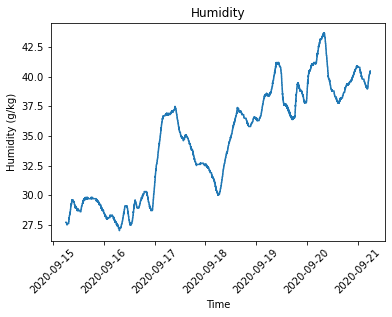

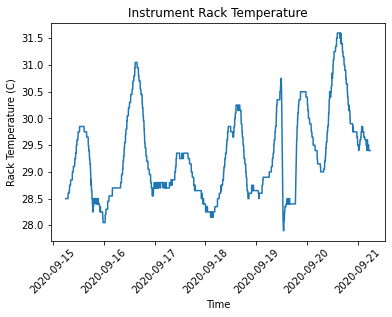

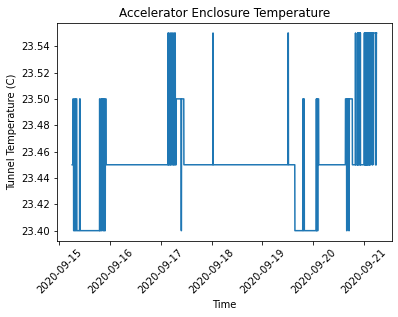

In [4]:
import matplotlib.pyplot as plt

plt.plot(humidity)
plt.title('Humidity')
plt.ylabel('Humidity (g/kg)')
plt.xlabel('Time')
plt.xticks(rotation = 45)
plt.show()

plt.plot(temp_rack)
plt.title('Instrument Rack Temperature')
plt.ylabel('Rack Temperature (C)')
plt.xlabel('Time')
plt.xticks(rotation = 45)
plt.show()

plt.plot(temp_tunnel)
plt.title('Accelerator Enclosure Temperature')
plt.ylabel('Tunnel Temperature (C)')
plt.xlabel('Time')
plt.xticks(rotation = 45)
plt.show()

The accelerator enclosure temperatures are very stable compared to the temperature and humidity in the tech hall, where the instrument racks are located.

In [5]:
pd.concat([humidity.describe(),temp_rack.describe(), temp_tunnel.describe()], axis =1)

,humidity,temp_rack,temp_tunnel
count,42037.000000,2069.000000,2071.000000
mean,34.664667,29.317569,23.449517
std,4.565252,0.821177,0.031504
min,27.000000,27.900000,23.400000
25%,29.700000,28.650000,23.450000
50%,35.800000,29.150000,23.450000
75%,38.500000,29.850000,23.450000
max,43.700000,31.600000,23.550000


Summary statistics above don't include range, which is calculated below:

In [6]:
print('Humidity range:', round(humidity.max().values[0] - humidity.min().values[0],2))
print('Rack Temperature range:', round(temp_rack.max().values[0] - temp_rack.min().values[0],2))
print('Tunnel Temperature range:', round(temp_tunnel.max().values[0] - temp_tunnel.min().values[0],2))

Humidity range: 16.7
Rack Temperature range: 3.7
Tunnel Temperature range: 0.15


### <font color='orange'>Evaluate Environmental Multicollinearity</font><a class="anchor" id="Multicollinearity"></a>
We know there is generally a relationship between humidity and air temperature in the natural environment, that as the temperature drops humidity increases and vice versa. So first, before testing whether temperature or humidity are affecting the beam, we need to know how independent they are in this environment.

In [7]:
env = pd.concat([humidity.resample('5T').mean(),temp_rack.resample('5T').mean(),temp_tunnel.resample('5T').mean()], axis = 1)

In [8]:
env.corr()

,humidity,temp_rack,temp_tunnel
humidity,1.000000,0.299013,0.236246
temp_rack,0.299013,1.000000,0.024390
temp_tunnel,0.236246,0.024390,1.000000


We note particularly low correlation between the temperatures in the tech hall versus accelerator enclosure. This means that any beam drift correlation with tunnel temperatures will likely be resulting from changes to the alignment of the vacuum chamber or possibly the coaxial cable terminations on the beam pickups within the vacuum chamber.

There is also low correlation between tech hall temperature and humidity, this is surprising but entirely possible given that the building has powerful (but unstable) climate control. Coaxial cable's susceptibility to moisture is known, and so if beam drift correlates with only humidity, it is likely that this is the mechanism through which the beam drift has occurred.

We'll plot these as well so we can be sure we haven't missed any non-linear relationship.

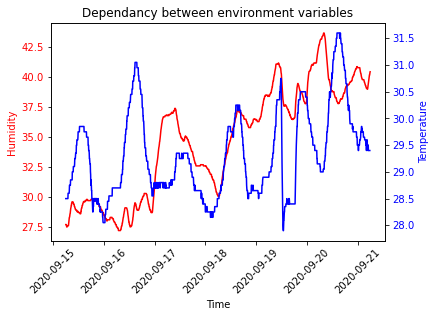

In [9]:
fig, ax1 = plt.subplots()

plt.xticks(rotation = 45)

ax1.set_xlabel('Time')
ax1.set_ylabel('Humidity', color='#ff0000')
ax1.plot(env.iloc[:, 0], color='#ff0000')
ax1.tick_params(axis='y', labelcolor='#ff0000')


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


ax2.set_ylabel('Temperature', color='#0000ff')  # we already handled the x-label with ax1
ax2.plot(env.iloc[:, 1], color='#0000ff')
ax2.tick_params(axis='y', labelcolor='#0000ff')

plt.title('Dependancy between environment variables')

plt.show()

It seem clear that for the most part that Temperature and Humidity do move independently. Although there certainly are times where the temperature and humidity do spike synchronously or inversely to one another. They seem more independent in the first half, particularly the 15th & 16th of Nov 2020.

### <font color='orange'> Preview Beam Position Monitoring (BPM) Data </font><a class="anchor" id="Beam"></a>
Quality check the beam position data.

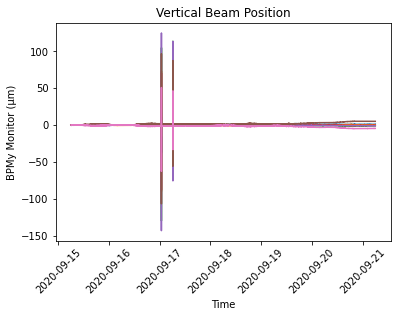

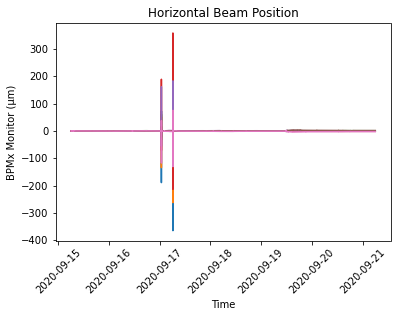

In [10]:
plt.plot(bpmy)
plt.title('Vertical Beam Position')
plt.ylabel('BPMy Monitor (μm)')
plt.xlabel('Time')
plt.xticks(rotation = 45)
plt.show()

plt.plot(bpmx)
plt.title('Horizontal Beam Position')
plt.ylabel('BPMx Monitor (μm)')
plt.xlabel('Time')
plt.xticks(rotation = 45)
plt.show()

The beam position plots show large perturbations in the vertical and horizontal beam position, we need to determine whether this is faulty data or relating to real beam perturbations.

![Electron Orbit Studies](LOCO-interference.png)

If the perturbations are minimal, it's possible we could use outlier methods to remove the unwanted data:

<AxesSubplot:>

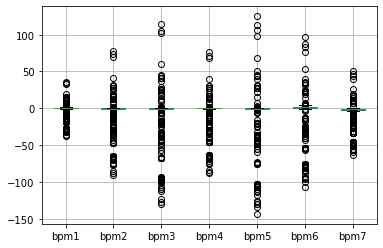

In [11]:
bpmy.boxplot()

Unfortunately, it appears the perturbations are extensive (more than just a couple of invalid data points), this needs a closer look.

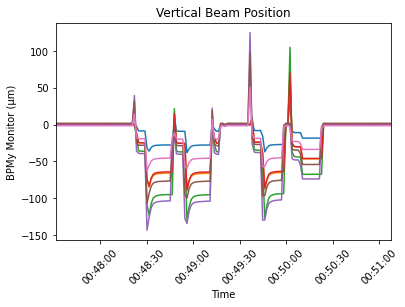

In [12]:
plt.plot(bpmy)
plt.title('Vertical Beam Position')
plt.ylabel('BPMy Monitor (μm)')
plt.xlabel('Time')
plt.xlim([18522.033, 18522.0355])
plt.xticks(rotation = 45)
plt.show()

Perturbations that follow this pattern are typically caused during machine studies when physicists need to measure the electron beam response to the magnets that control the beam positioning, this is referred to as a LOCO (Linear Optical from Closed Orbits) measurement. This data needs to be excluded, as the beam is not moving as a result of the environmental changes that we're trying to measure, but rather being driven by magnetic field changes.

### <font color='orange'>Trim the LOCO data</font><a class="anchor" id="Trim"></a>

Below we trim the data to exclude the problematic period where LOCO measurement is taken. The first cell block specifies the period before the LOCO, as we feel that temperature and humidity are acting most independently there. The second code cell can be uncommented to explore the data after the LOCO.

Run this to analyse the small segment of data before LOCO disturbance:

In [13]:
# bpmy has LOCO data between index 100000 - 130000
#Set sub-potion of data by start & end index
bpmy_end = 100000

# bpmx has bad data between 50000 - 51800
#Set sub-potion of data by start & end index
bpmx_end = 45000

# Drop Nans and trim loco data
bpmy_trim = bpmy.iloc[:bpmy_end]
bpmx_trim = bpmx.iloc[:bpmx_end]
temp_rack_trim = temp_rack
temp_tunnel_trim = temp_tunnel
humidity_trim = humidity

bpmy_trim.head

<bound method NDFrame.head of                              bpm1   bpm2   bpm3   bpm4   bpm5   bpm6   bpm7
bpm_t                                                                      
2020-09-15 06:00:00.000000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
2020-09-15 06:00:01.356440  0.000  0.000  0.000  0.000  0.000  0.000  0.000
2020-09-15 06:00:02.712870  0.000  0.000  0.045  0.000  0.000  0.000  0.000
2020-09-15 06:00:04.069300  0.000  0.000  0.045  0.000  0.000  0.000  0.000
2020-09-15 06:00:05.425740  0.000  0.000  0.045  0.000  0.000  0.000  0.000
...                           ...    ...    ...    ...    ...    ...    ...
2020-09-16 19:40:36.818443  0.292  0.347 -0.543 -0.117 -0.255  1.701 -1.542
2020-09-16 19:40:38.174883  0.292  0.347 -0.543 -0.117 -0.255  1.701 -1.542
2020-09-16 19:40:39.531323  0.292  0.347 -0.591 -0.117 -0.255  1.701 -1.542
2020-09-16 19:40:40.887753  0.292  0.347 -0.591 -0.117 -0.255  1.701 -1.542
2020-09-16 19:40:42.244183  0.292  0.347 -0.591 -0.117 -0.

Or run this for the larger segment of data after the LOCO measurement

In [14]:
# bpmy has LOCO data between 100000 - 130000
#Set sub-potion of data by start & end index
#bpmy_start = 130000 

# bpmx has bad data between 50000 - 51800
# Set sub-potion of data by start & end index
#bpmx_start = 51800 

# Drop Nans and trim loco data
#bpmy_trim = bpmy.iloc[bpmy_start:].dropna()
#bpmx_trim = bpmx.iloc[bpmx_start:].dropna()
#temp_rack_trim = temp_rack.dropna()
#temp_tunnel_trim = temp_tunnel.dropna()
#humidity_trim = humidity.dropna()

Having seen the results, the longer timeframe above adds complexity to understanding the problem and isn't helpful for initial findings. But it is interesting to see once the findings are understood. Feel free to uncomment and run the notebook from the above section once you reach the end.

## <font color='coral'>Resample Data</font><a class="anchor" id="Resample"></a>
The beam data is sampled at a higher frequency that the environmental data. Each variable is re-sampled so that the timing intervals of both datasets match and can be used in a tabular format. The resample method uses the the mean value within a 5 minute window.

In [15]:
all_y = pd.concat([bpmy_trim.resample('5T').mean(), 
                   temp_rack_trim.resample('5T').mean(), 
                   temp_tunnel_trim.resample('5T').mean(), 
                   humidity_trim.resample('5T').mean()], 
                  axis=1).dropna()

all_x = pd.concat([bpmx_trim.resample('5T').mean(), 
                   temp_rack_trim.resample('5T').mean(), 
                   temp_tunnel_trim.resample('5T').mean(), 
                   humidity_trim.resample('5T').mean()], 
                  axis=1).dropna()


## <font color='coral'> Visualise Synchrony </font> <a class="anchor" id="Vis"></a>
Now that all our data is synchronised in a tabular format, it can be overlaid in a single plot.

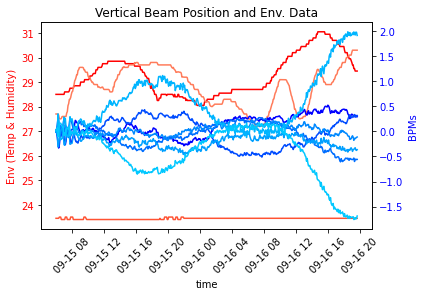

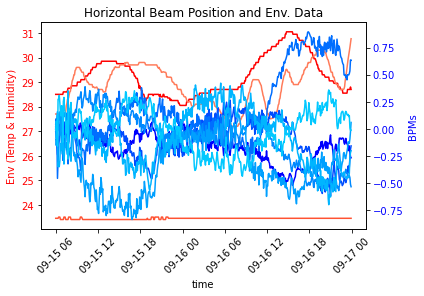

In [16]:
# yplot
#############################

fig, ax1 = plt.subplots()
plt.xticks(rotation = 45)
ax1.set_xlabel('time')
ax1.set_ylabel('Env (Temp & Humidity)', color='#ff0000')
ax1.plot(all_y.iloc[:, 7], color='#ff0000')
ax1.plot(all_y.iloc[:, 8], color='#ff5232')
ax1.plot(all_y.iloc[:, 9], color='#ff7b5a')
ax1.tick_params(axis='y', labelcolor='#ff0000')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('BPMs', color='#0000ff')  # we already handled the x-label with ax1
ax2.plot(all_y.iloc[:, 0], color='#0000ff')
ax2.plot(all_y.iloc[:, 1], color='#004cff')
ax2.plot(all_y.iloc[:, 2], color='#006eff')
ax2.plot(all_y.iloc[:, 3], color='#0089ff')
ax2.plot(all_y.iloc[:, 4], color='#00a0ff')
ax2.plot(all_y.iloc[:, 5], color='#00b5ff')
ax2.plot(all_y.iloc[:, 6], color='#02c8ff')
ax2.tick_params(axis='y', labelcolor='#0000ff')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Vertical Beam Position and Env. Data')
plt.show()

# xplot
##################################

fig, ax1 = plt.subplots()
plt.xticks(rotation = 45)
ax1.set_xlabel('time')
ax1.set_ylabel('Env (Temp & Humidity)', color='#ff0000')
ax1.plot(all_x.iloc[:, 7], color='#ff0000')
ax1.plot(all_x.iloc[:, 8], color='#ff5232')
ax1.plot(all_x.iloc[:, 9], color='#ff7b5a')
ax1.tick_params(axis='y', labelcolor='#ff0000')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


ax2.set_ylabel('BPMs', color='#0000ff')  # we already handled the x-label with ax1
ax2.plot(all_x.iloc[:, 0], color='#0000ff')
ax2.plot(all_x.iloc[:, 1], color='#004cff')
ax2.plot(all_x.iloc[:, 2], color='#006eff')
ax2.plot(all_x.iloc[:, 3], color='#0089ff')
ax2.plot(all_x.iloc[:, 4], color='#00a0ff')
ax2.plot(all_x.iloc[:, 5], color='#00b5ff')
ax2.plot(all_x.iloc[:, 6], color='#02c8ff')
ax2.tick_params(axis='y', labelcolor='#0000ff')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Horizontal Beam Position and Env. Data')
plt.show()

It's a bit difficult to see with all the Beam Position Monitors (BPMs) overlaid, but it appears as though there will be a high correlation between one of our env parameters and the vertical beam positions, some will negatively correlate while others will positively correlate.

Below we filter some variables to show that relationship symmetry more clearly.

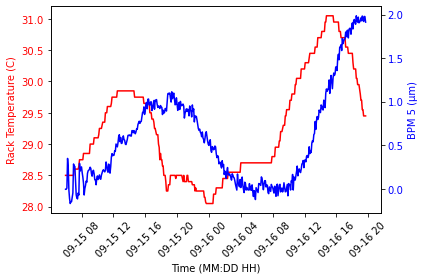

In [48]:
fig, ax1 = plt.subplots()
plt.xticks(rotation = 45)
ax1.set_xlabel('Time (MM:DD HH)')
ax1.set_ylabel('Rack Temperature (C)', color='#ff0000')
ax1.plot(all_y.iloc[:, 7], color='#ff0000')
ax1.tick_params(axis='y', labelcolor='#ff0000')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('BPM 5 (μm)', color='#0000ff')  # we already handled the x-label with ax1
ax2.plot(all_y.iloc[:, 5], color='#0000ff')
ax2.tick_params(axis='y', labelcolor='#0000ff')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Interestingly, there appears to be a time lag, although the positive correlation symmetry is very clear.

A second example below:

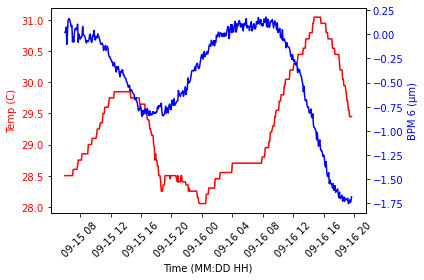

In [47]:
fig, ax1 = plt.subplots()
plt.xticks(rotation = 45)
ax1.set_xlabel('Time (MM:DD HH)')
ax1.set_ylabel('Temp (C)', color='#ff0000')
ax1.plot(all_y.iloc[:, 7:8], color='#ff0000')
ax1.tick_params(axis='y', labelcolor='#ff0000')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('BPM 6 (μm)', color='#0000ff')  # we already handled the x-label with ax1
ax2.plot(all_y.iloc[:, 6:7], color='#0000ff')
ax2.tick_params(axis='y', labelcolor='#0000ff')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In this instance we see symmetry which we expect to show a strong negative correlation.

Below are the initial unadjusted correlation coefficient (R), for interests sake:

#### Vertical beam correlation with environment

In [19]:
all_y.corr().loc[['temp_rack', 'temp_tunnel', 'humidity'],['bpm1', 'bpm2', 'bpm3', 'bpm4', 'bpm5', 'bpm6', 'bpm7']]


,bpm1,bpm2,bpm3,bpm4,bpm5,bpm6,bpm7
temp_rack,0.640874,0.013932,-0.544230,-0.041750,0.103896,0.455631,-0.529519
temp_tunnel,0.216463,-0.283852,0.137795,0.250915,-0.145261,0.008516,0.015509
humidity,-0.149251,0.736561,-0.731679,-0.647069,-0.470508,0.695193,-0.690796


#### Horizontal beam correlation with environment

In [20]:
all_x.corr().loc[['temp_rack', 'temp_tunnel', 'humidity'],['bpm1', 'bpm2', 'bpm3', 'bpm4', 'bpm5', 'bpm6', 'bpm7']]

,bpm1,bpm2,bpm3,bpm4,bpm5,bpm6,bpm7
temp_rack,-0.834854,0.195115,0.474713,-0.169458,-0.596836,-0.136179,0.162011
temp_tunnel,-0.165090,0.012785,0.170834,-0.460416,0.485351,0.136495,-0.305734
humidity,-0.045672,-0.651987,0.463298,-0.199536,-0.567830,-0.699645,0.645703


There are clearly elements of correlation between the beam position on each BPM and each env variable. Some BPMs appear to have higher correlation with humidity than temperature.

Below we scatter plot each BPM againts each environmental monitor.

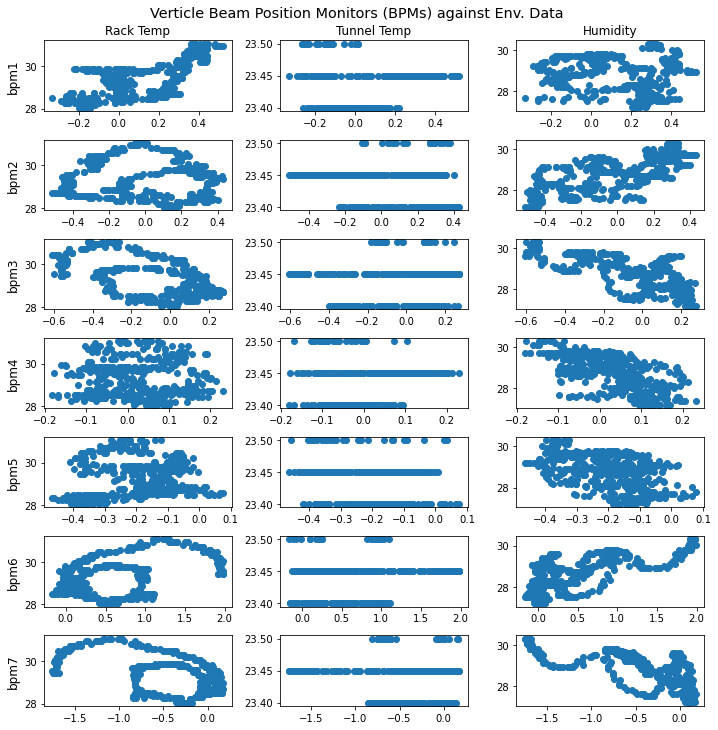

In [55]:
import matplotlib.pyplot as plt

# Subplot formatting
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(10, 10))

# Col and row lables
rows = ['bpm1', 'bpm2', 'bpm3', 'bpm4', 'bpm5', 'bpm6', 'bpm7']
cols = ['Rack Temp','Tunnel Temp','Humidity']

# Fill plots with data
for i in range(7):
    axes[i][0].scatter(all_y[rows[i]],all_y['temp_rack'])
    axes[i][1].scatter(all_y[rows[i]],all_y['temp_tunnel'])
    axes[i][2].scatter(all_y[rows[i]],all_y['humidity'])

for ax, col in zip(axes[0], cols):
    ax.set_title(col)
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, size='large')

plt.tight_layout()
fig.suptitle("Verticle Beam Position Monitors (BPMs) against Env. Data", fontsize="x-large",  y=1.01)
plt.show()

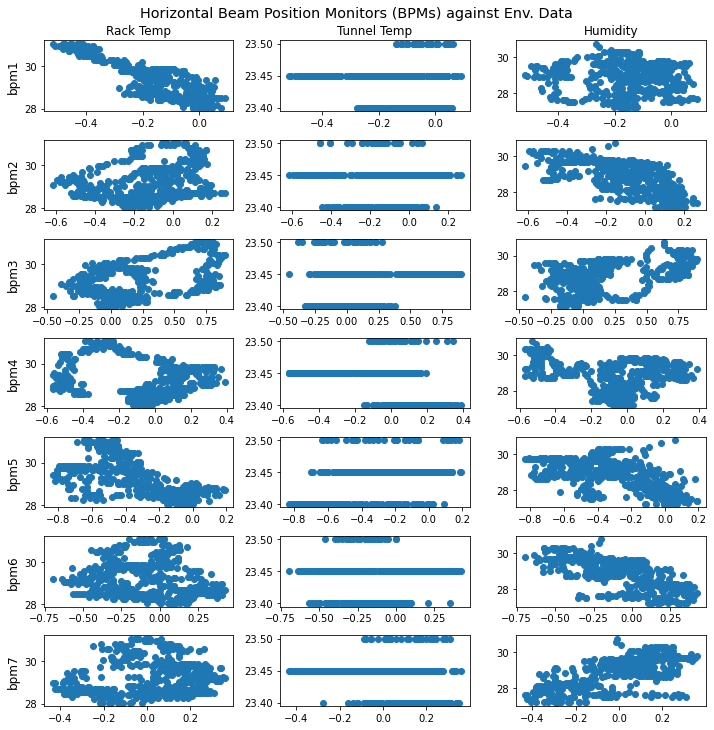

In [54]:
import matplotlib.pyplot as plt

# Subplot formatting
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(10, 10))

# Col and row lables
rows = ['bpm1', 'bpm2', 'bpm3', 'bpm4', 'bpm5', 'bpm6', 'bpm7']
cols = ['Rack Temp','Tunnel Temp','Humidity']

# Fill plots with data
for i in range(7):
    axes[i][0].scatter(all_x[rows[i]],all_x['temp_rack'])
    axes[i][1].scatter(all_x[rows[i]],all_x['temp_tunnel'])
    axes[i][2].scatter(all_x[rows[i]],all_x['humidity'])

for ax, col in zip(axes[0], cols):
    ax.set_title(col)
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, size='large')

plt.tight_layout()
fig.suptitle("Horizontal Beam Position Monitors (BPMs) against Env. Data", fontsize="x-large",  y=1.01)
plt.show()

This looks very interesting, it appears the curly patterns seen in a lot of the scatter plots could be the result of the time difference between the environment change and beam drift. It's clear that we'll need to correct for that if we're going to gain anything useful from correlating these variables.

## <font color='coral'> Time Lag Analysis </font><a class="anchor" id="Lag"></a>

We noticeded above there was a time lag between cause (environment change) and effect (beam position drift), we need to know exactly how long this lag period is and add an offset to the data so that we can obtain better correlation estimates.

![time Lag](time-lag.png)

It's unclear why there is a time lag, it could be related to poor air flow around the temperature monitoring, or insulation provided by housing the instruments in racks. This will be a consideration for future improvements if this work continues.

Since the difference between peaks falls within an estimated eight hour window, we'll use time lagged cross correlation for the first 100 data points (8.3hrs) of data to try and identify the precise lag we should apply. This will be done by indexing the time at which the correlation constant is maximised for all BPMs. We expect to be able to average the lag on all BPMs to find a universal delay.

Below, the time lagged cross correlation is computed for the entire set of environment variables against BPMs. The first eight hours of correlation constant values are then plotted:

In [23]:
cor_lag_y = np.zeros(shape=(1,21))

# Removetail from BPMs and head from env data, as we anticipate that rack temp will preceed bpm effects
for i in range(0,len(all_y)-1):
    data_bpms = all_y.iloc[0+i:len(all_y),:]
    data_env = all_y.iloc[0:len(all_y)-i,:]
    data = pd.concat([data_bpms.iloc[:,0:7].reset_index(), data_env.iloc[:,7:10].reset_index()], axis = 1)
    cor = data.corr().loc[['temp_rack', 'temp_tunnel', 'humidity'],['bpm1', 'bpm2', 'bpm3', 'bpm4', 'bpm5', 'bpm6', 'bpm7']]
    cor_lag_y = np.vstack((cor_lag_y, cor.values.flatten()))

cor_lag_x = np.zeros(shape=(1,21))

# Removetail from BPMs and head from env data, as we anticipate that rack temp will preceed bpm effects
for i in range(0,len(all_x)-1):
    data_bpms = all_x.iloc[0+i:len(all_x),:]
    data_env = all_x.iloc[0:len(all_x)-i,:]
    data = pd.concat([data_bpms.iloc[:,0:7].reset_index(), data_env.iloc[:,7:10].reset_index()], axis = 1)
    cor = data.corr().loc[['temp_rack', 'temp_tunnel', 'humidity'],['bpm1', 'bpm2', 'bpm3', 'bpm4', 'bpm5', 'bpm6', 'bpm7']]
    cor_lag_x = np.vstack((cor_lag_x, cor.values.flatten()))

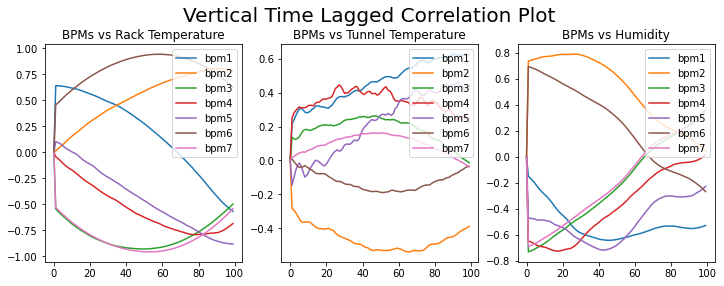

In [35]:
cor_lag_y = pd.DataFrame(cor_lag_y)
cor_lag_y.columns = ['bpm1', 'bpm2', 'bpm3', 'bpm4', 'bpm5', 'bpm6', 'bpm7', 'bpm1', 'bpm2', 'bpm3', 'bpm4', 'bpm5', 'bpm6', 'bpm7', 'bpm1', 'bpm2', 'bpm3', 'bpm4', 'bpm5', 'bpm6', 'bpm7']

fig, axes= plt.subplots(nrows=1, ncols=3)

axes[0].set_title('BPMs vs Rack Temperature')
axes[0].plot(cor_lag_y.iloc[0:100,0:7])
axes[0].legend(list(cor_lag_y.iloc[:,0:7].columns), loc = 'upper right')


axes[1].set_title('BPMs vs Tunnel Temperature')
axes[1].plot(cor_lag_y.iloc[0:100:,7:14])
axes[1].legend(list(cor_lag_y.iloc[:,7:14].columns), loc = 'upper right')


axes[2].set_title('BPMs vs Humidity')
axes[2].plot(cor_lag_y.iloc[0:100,14:21])
axes[2].legend(list(cor_lag_y.iloc[:,14:21].columns), loc = 'upper right')

fig.suptitle('Vertical Time Lagged Correlation Plot', fontsize=20, y=1.01)

fig.set_figwidth(12)

plt.show()

These are very unexpected results! We expected similar lag results across every BPM given they are house in the same environmental conditions, but as you see above, the correlation constant peaks for some BPMs much later than others. It should be noted that BPMs 1-4 are connected to the same signal processing instrument while BPM's 5-7 are connected to the next instrument directly below the first (in the same rack). There are no patterns emerging that reflect this geometry, this would suggest that the instrument is unaffected. Its possible that the lag differences could be associated with differing coaxial cable length, how secure the termination at the instrument and sensors are or many other factors. Unfortunately is does cast doubt on the likelihood that the signal processing instruments are affected by thermal drift, as we expect to see a much more synchronised effect for signals processed by the same device.

#### Rack Temperature Correlation:
The most highly correlated BPMs (BPM 3, 6 & 7) are almost perfectly correlated at index/x-axis = 50, each data point corresponds to 5 minutes, so the lag period = 50 x 5 = 250mins = 4hrs. BPMs with lower correlation also appear to be more delayed.

#### Tunnel Temperature Correlation:
If anything, this is a fraction more delayed than the Rack Temperatures effect, and less highly correlated - this could be explained by the fact that the tunnels retrieve their air from the Tech Hall (where the racks are located) with additional air-conditioning on the way in.

#### Humidity:
Sometimes the humidity effects are lagged (e.g. bpm5, bpm4, bpm2) and in other instances they aren't (e.g. bpm7 & bpm3).

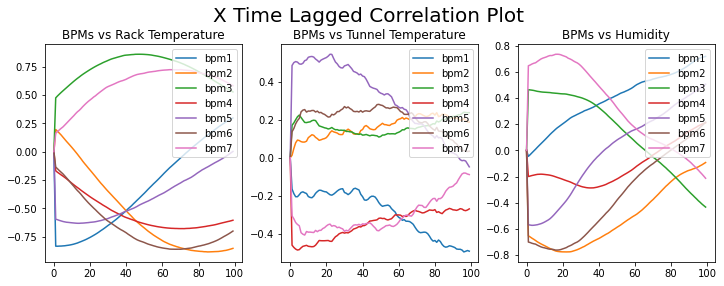

In [36]:
cor_lag_x = pd.DataFrame(cor_lag_x)
cor_lag_x.columns = ['bpm1', 'bpm2', 'bpm3', 'bpm4', 'bpm5', 'bpm6', 'bpm7', 'bpm1', 'bpm2', 'bpm3', 'bpm4', 'bpm5', 'bpm6', 'bpm7', 'bpm1', 'bpm2', 'bpm3', 'bpm4', 'bpm5', 'bpm6', 'bpm7']

fig, axes= plt.subplots(nrows=1, ncols=3)

axes[0].set_title('BPMs vs Rack Temperature')
axes[0].plot(cor_lag_x.iloc[0:100,0:7])
axes[0].legend(list(cor_lag_x.iloc[:,0:7].columns), loc = 'upper right')


axes[1].set_title('BPMs vs Tunnel Temperature')
axes[1].plot(cor_lag_x.iloc[0:100,7:14])
axes[1].legend(list(cor_lag_x.iloc[:,7:14].columns), loc = 'upper right')


axes[2].set_title('BPMs vs Humidity')
axes[2].plot(cor_lag_x.iloc[0:100,14:21])
axes[2].legend(list(cor_lag_x.iloc[:,14:21].columns), loc = 'upper right')

fig.suptitle('X Time Lagged Correlation Plot', fontsize=20, y=1.01)

fig.set_figwidth(12)

plt.show()

The horizontal beam effects are very much similar to the vertical effects.

### <font color='orange'> Quantify Time Lag </font><a class="anchor" id="QLag"></a>

The table below grabs the peak correlation index for each BPM and env factor within the specified window (correlation is likely to increase as the window moves, leaving less and less data in the window, so we have constrained the lag window to the first set of peaks)

In [38]:
# delay is simply quantified by the index of the data

delay_track_y = cor_lag_y.iloc[0:100,0:7].abs().idxmax()
delay_track_y = delay_track_y.reset_index()[0]

delay_ttunnel_y = cor_lag_y.iloc[0:100,7:14].abs().idxmax()
delay_ttunnel_y = delay_ttunnel_y.reset_index()[0]

delay_humid_y = cor_lag_y.iloc[0:100,14:21].abs().idxmax()
delay_humid_y = delay_humid_y.reset_index()[0]

delay_track_x = cor_lag_x.iloc[0:100,0:7].abs().idxmax()
delay_track_x = delay_track_x.reset_index()[0]

delay_ttunnel_x = cor_lag_x.iloc[0:100,7:14].abs().idxmax()
delay_ttunnel_x = delay_ttunnel_x.reset_index()[0]

delay_humid_x = cor_lag_x.iloc[0:100,14:21].abs().idxmax()
delay_humid_x = delay_humid_x.reset_index()[0]

delay = pd.DataFrame({
    'temp_rack_x': delay_track_x,
    'temp_rack_y': delay_track_y,
    'temp_tunnel_x': delay_ttunnel_x,
    'temp_tunnel_y': delay_ttunnel_y,
    'humidity_x': delay_humid_x,
    'humidity_y': delay_humid_y
})
delay = delay.T
delay.columns = ['bpm1', 'bpm2', 'bpm3', 'bpm4', 'bpm5', 'bpm6', 'bpm7']
delay

,bpm1,bpm2,bpm3,bpm4,bpm5,bpm6,bpm7
temp_rack_x,2,85,47,72,14,70,64
temp_rack_y,1,91,50,77,98,59,53
temp_tunnel_x,96,81,96,4,22,49,8
temp_tunnel_y,97,66,46,27,93,51,51
humidity_x,99,22,1,35,3,16,17
humidity_y,46,27,1,17,42,1,1


### <font color=orange>Apply Lag</font><a class="anchor" id="ALag"></a>
It's clear that we can't apply the same lag to every variable as we initially planned to do, so instead we'll create a dataframe for each of the environmental variables and apply the lag from the table above which maximises correlation.

In [39]:
synch_temp_rack_x = all_x.temp_rack.reset_index().drop(columns = ['index'])
synch_temp_rack_y = all_y.temp_rack.reset_index().drop(columns = ['index'])

synch_temp_tunnel_x = all_x.temp_tunnel.reset_index().drop(columns = ['index'])
synch_temp_tunnel_y = all_y.temp_tunnel.reset_index().drop(columns = ['index'])

synch_humidity_x = all_x.humidity.reset_index().drop(columns = ['index'])
synch_humidity_y = all_y.humidity.reset_index().drop(columns = ['index'])

for bpm in delay.columns:
    synch_temp_rack_x = pd.concat([synch_temp_rack_x, all_x[bpm].shift(-delay.loc[['temp_rack_x'], [bpm]].values[0,0]).reset_index().drop(columns = ['index'])], axis = 1)
    synch_temp_rack_y = pd.concat([synch_temp_rack_y, all_y[bpm].shift(-delay.loc[['temp_rack_y'], [bpm]].values[0,0]).reset_index().drop(columns = ['index'])], axis = 1)
    
    synch_temp_tunnel_x = pd.concat([synch_temp_tunnel_x, all_y[bpm].shift(-delay.loc[['temp_tunnel_x'], [bpm]].values[0,0]).reset_index().drop(columns = ['index'])], axis = 1)
    synch_temp_tunnel_y = pd.concat([synch_temp_tunnel_y, all_y[bpm].shift(-delay.loc[['temp_tunnel_y'], [bpm]].values[0,0]).reset_index().drop(columns = ['index'])], axis = 1)

    synch_humidity_x = pd.concat([synch_humidity_x, all_y[bpm].shift(-delay.loc[['humidity_x'], [bpm]].values[0,0]).reset_index().drop(columns = ['index'])], axis = 1)
    synch_humidity_y = pd.concat([synch_humidity_y, all_y[bpm].shift(-delay.loc[['humidity_y'], [bpm]].values[0,0]).reset_index().drop(columns = ['index'])], axis = 1)

synch_temp_rack_x.dropna(inplace=True)
synch_temp_rack_y.dropna(inplace=True)
synch_temp_tunnel_x.dropna(inplace=True)
synch_temp_tunnel_y.dropna(inplace=True)
synch_humidity_x.dropna(inplace=True)
synch_humidity_y.dropna(inplace=True)

## <font color=coral>Analysis of re-synchronised data</font><a class="anchor" id="ASynched"></a>

Measure R after synchronisation of data

<AxesSubplot:>

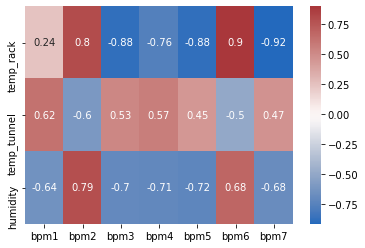

In [40]:
corr_coeffs_x = pd.DataFrame()
corr_coeffs_y = pd.DataFrame()

corr_coeffs_x = corr_coeffs_x.append(synch_temp_rack_x.corr().loc[['temp_rack'],['bpm1', 'bpm2', 'bpm3', 'bpm4', 'bpm5', 'bpm6', 'bpm7']])
corr_coeffs_y = corr_coeffs_y.append(synch_temp_rack_y.corr().loc[['temp_rack'],['bpm1', 'bpm2', 'bpm3', 'bpm4', 'bpm5', 'bpm6', 'bpm7']])

corr_coeffs_x = corr_coeffs_x.append(synch_temp_tunnel_x.corr().loc[['temp_tunnel'],['bpm1', 'bpm2', 'bpm3', 'bpm4', 'bpm5', 'bpm6', 'bpm7']])
corr_coeffs_y = corr_coeffs_y.append(synch_temp_tunnel_y.corr().loc[['temp_tunnel'],['bpm1', 'bpm2', 'bpm3', 'bpm4', 'bpm5', 'bpm6', 'bpm7']])

corr_coeffs_x = corr_coeffs_x.append(synch_humidity_x.corr().loc[['humidity'],['bpm1', 'bpm2', 'bpm3', 'bpm4', 'bpm5', 'bpm6', 'bpm7']])
corr_coeffs_y = corr_coeffs_y.append(synch_humidity_y.corr().loc[['humidity'],['bpm1', 'bpm2', 'bpm3', 'bpm4', 'bpm5', 'bpm6', 'bpm7']])

%matplotlib inline
import seaborn as sns
sns.heatmap(corr_coeffs_y, annot=True, cmap = "vlag")

<AxesSubplot:>

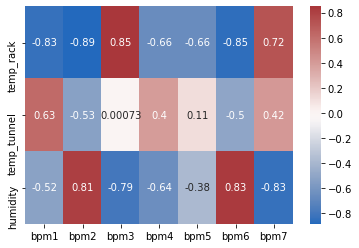

In [42]:
sns.heatmap(corr_coeffs_x, annot=True, cmap = "vlag")

As seen before, correlation with rack temperature and humidity is highest. We have used a much smaller subset of data than we initially tested multicollinearity on. Let's quickly re-check correlation between the env variables:

In [43]:
all_x.corr().loc[['temp_rack', 'temp_tunnel', 'humidity'],['temp_rack', 'temp_tunnel', 'humidity']]

,temp_rack,temp_tunnel,humidity
temp_rack,1.000000,-0.088459,0.185996
temp_tunnel,-0.088459,1.000000,-0.243849
humidity,0.185996,-0.243849,1.000000


This is as low as we previously found. So it's clear that humidity and temperature in the tech hall are both impacting the beam via independent mechanisms.

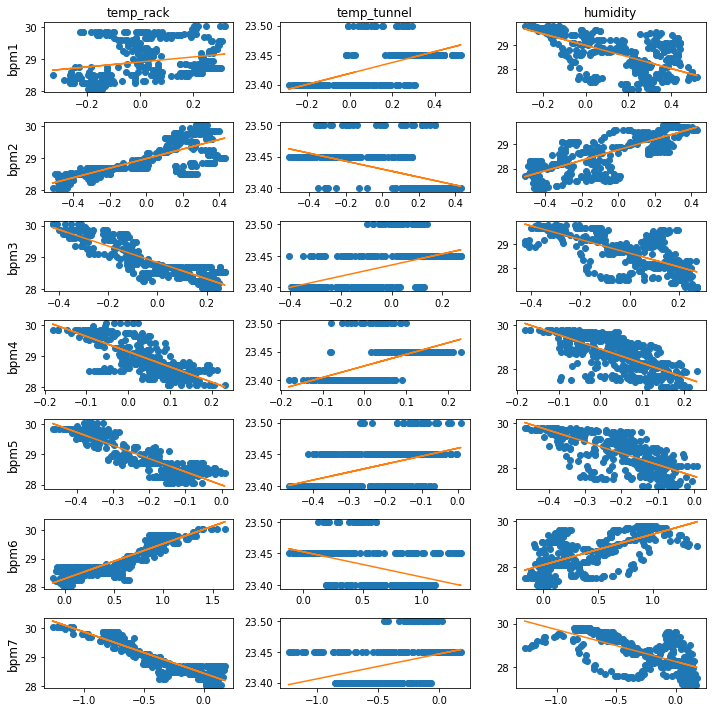

In [53]:
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit

# Subplot formatting
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(10, 10))

# Col and row lables
rows = ['bpm1', 'bpm2', 'bpm3', 'bpm4', 'bpm5', 'bpm6', 'bpm7']
cols = ['temp_rack','temp_tunnel','humidity']

# Fill plots with data
for i in range(7):
    axes[i][0].scatter(synch_temp_rack_y[rows[i]],synch_temp_rack_y['temp_rack'])
    b, m = polyfit(synch_temp_rack_y[rows[i]], synch_temp_rack_y['temp_rack'], 1)
    axes[i][0].plot(synch_temp_rack_y[rows[i]], synch_temp_rack_y['temp_rack'], '.')
    axes[i][0].plot(synch_temp_rack_y[rows[i]], b + m * synch_temp_rack_y[rows[i]], '-')
    
    
    axes[i][1].scatter(synch_temp_tunnel_y[rows[i]],synch_temp_tunnel_y['temp_tunnel'])
    b, m = polyfit(synch_temp_tunnel_y[rows[i]], synch_temp_tunnel_y['temp_tunnel'], 1)
    axes[i][1].plot(synch_temp_tunnel_y[rows[i]], synch_temp_tunnel_y['temp_tunnel'], '.')
    axes[i][1].plot(synch_temp_tunnel_y[rows[i]], b + m * synch_temp_tunnel_y[rows[i]], '-')
    
    axes[i][2].scatter(synch_humidity_y[rows[i]],synch_humidity_y['humidity'])
    b, m = polyfit(synch_humidity_y[rows[i]], synch_humidity_y['humidity'], 1)
    axes[i][2].plot(synch_humidity_y[rows[i]], synch_humidity_y['humidity'], '.')
    axes[i][2].plot(synch_humidity_y[rows[i]], b + m * synch_humidity_y[rows[i]], '-')    
    

for ax, col in zip(axes[0], cols):
    ax.set_title(col)
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, size='large')

plt.tight_layout()
plt.show()

This shows again that correlation with rack temperatures and humidity are very high but that there are certainly other factors still influencing beam stability. These results for longer segments of data (after the LOCO measurement) were less conclusive, as the curly patterns seen in the unsynchronised data become even more pronounced (go back and uncomment the data from after the LOCO to see this).

There are some long term factors that could reduce correlation over time; automatic gain control on the instrument could have changed, an orbit correction could have unintentionally moved the beam position or insertion devices could also be scanning and disturbing the beam as well. Fit for purpose data will be required to be collected with tighter experimental controls to eliminate these possibilities.

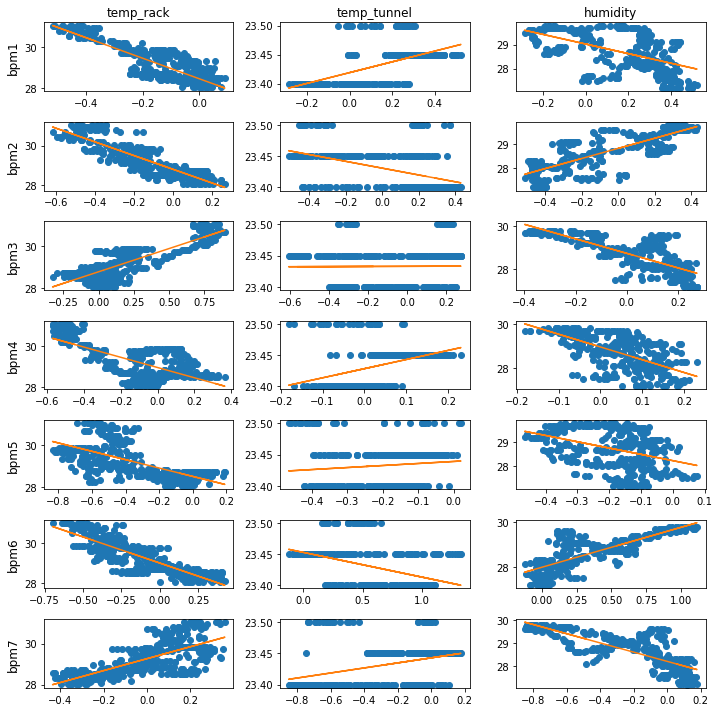

In [32]:
# Subplot formatting
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(10, 10))

# Col and row lables
rows = ['bpm1', 'bpm2', 'bpm3', 'bpm4', 'bpm5', 'bpm6', 'bpm7']
cols = ['temp_rack','temp_tunnel','humidity']

# Fill plots with data
for i in range(7):
    axes[i][0].scatter(synch_temp_rack_x[rows[i]],synch_temp_rack_x['temp_rack'])
    b, m = polyfit(synch_temp_rack_x[rows[i]], synch_temp_rack_x['temp_rack'], 1)
    axes[i][0].plot(synch_temp_rack_x[rows[i]], synch_temp_rack_x['temp_rack'], '.')
    axes[i][0].plot(synch_temp_rack_x[rows[i]], b + m * synch_temp_rack_x[rows[i]], '-')
    
    
    axes[i][1].scatter(synch_temp_tunnel_x[rows[i]],synch_temp_tunnel_x['temp_tunnel'])
    b, m = polyfit(synch_temp_tunnel_x[rows[i]], synch_temp_tunnel_x['temp_tunnel'], 1)
    axes[i][1].plot(synch_temp_tunnel_x[rows[i]], synch_temp_tunnel_x['temp_tunnel'], '.')
    axes[i][1].plot(synch_temp_tunnel_x[rows[i]], b + m * synch_temp_tunnel_x[rows[i]], '-')
    
    axes[i][2].scatter(synch_humidity_x[rows[i]],synch_humidity_x['humidity'])
    b, m = polyfit(synch_humidity_x[rows[i]], synch_humidity_x['humidity'], 1)
    axes[i][2].plot(synch_humidity_x[rows[i]], synch_humidity_x['humidity'], '.')
    axes[i][2].plot(synch_humidity_x[rows[i]], b + m * synch_humidity_x[rows[i]], '-')    
    

for ax, col in zip(axes[0], cols):
    ax.set_title(col)
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, size='large')

plt.tight_layout()
plt.show()

Lower correlation on the horizontal axis, but there is still clearly an impact from environment fluctuations, both humudity and temperature in the tech hall.

# <font color=coral> Key Learning:</font><a class="anchor" id="KLearn"></a>
- The vertical beam effect seems most aligned with the temperatures measured near the instrument racks, but it's clear that humidity also has a substantial effect, both are impacting the beam through independent mechanisms.
- The varying degree of lag experienced by BPMs which are connected to the same instrument casts doubt on the likelihood that adding climate controls to the instrument racks will improve stability, it calls into question whether miss-matched coaxial cable lengths/paths or loose cable terminations could be responsible. More information and planned experimentation is required.
- Temperature stability measured on the vacuum chamber had the lowest correlation with beam movement, it's unlikely that the vacuum chamber and sensors are moving relative to the beam.

# <font color=coral> Future Improvements:</font><a class="anchor" id="Future"></a>
- Experiments during which the humidity and temperature in the instrument racks are more closely controlled and monitored would improve knowledge of the source of the problem.
- Further developing functions which request data directly from the archive appliance and assess any/all positions across the accelerator would help improve results as well.
- There are significant lengths of coaxial cable between the accelerator enclosure and the instrument racks, it's very likely that they are responsible for all drift complications. Experiments should be designed specifically to assess this as well.

### <font color=orange> Accelerator Parameters:</font><a class="anchor" id="AccParam"></a>
The following operational parameters may have impacted the data collected for this analysis, they need to be controlled in the next round of data collection:
- Turn all instrument (Libera) auto-gain controls off
- Insertion devices must be withdrawn and disabled
- Orbit feedbacks must be disabled, preventing unwanted corrections to the beam position

### <font color=orange> Futher Questions:</font><a class="anchor" id="FQ"></a>
- An alternative cause may be that ambient temperatures could be causing the voltage/current of the Magnet Power Supplies to drifts, causing real shifts in the beam rather than perceived ones on the beam position monitors.
- Variation in the degree of correlation and delay in effect may hold the answer, careful consideration of the physical mechanisms through which this could occur should be re-considered.

# <font color=coral> Conclusion:</font><a class="anchor" id="Conc"></a>
We set out to answer whether only temperature or humidity were primarily influencing the beam drift and found that both are responsible. We also wanted to narrow down the physical mechanism responsible, we have found that the vacuum chamber and signal processing instruments are not likely to be responsible. More likely candidates include the coaxial cables sensitivity to humidity and possibly the combination of low connection integrity between cable terminations and devices, and their sensitivity to temperature.


The main question we set out to answer at the beginning was whether climate control for the instrumentation racks could provide greater beam stability. The answer found was that the instruments in question are unlikely to be affected by the temperature and humidity fluctuations observed, however it's possible that climate control could still have an impact through mechanisms not yet explored. Further recommendations were provided for improved data collection, experimentation and mechanisms that could be explored.